**Youtube Comments Spam Detection**

Library

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
import re

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Dataset

In [ ]:
df = pd.read_csv('/content/Youtube-Spam-Dataset.csv')
df.head(5)

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


Pre-processing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


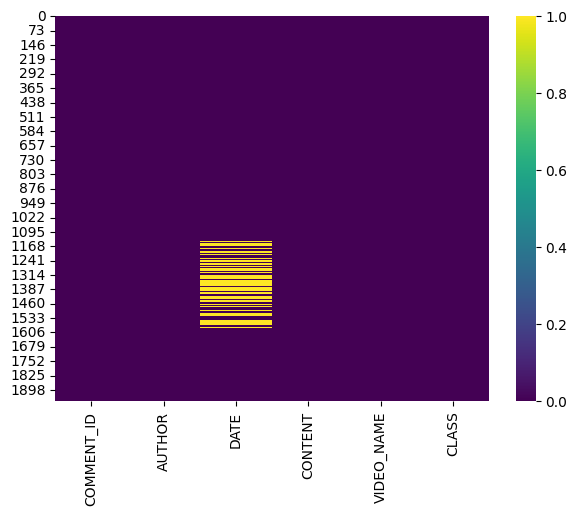

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.heatmap(df.isnull(),  cmap='viridis')
plt.show()


In [ ]:
df.duplicated().sum()

3

In [ ]:

df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Data Analysis

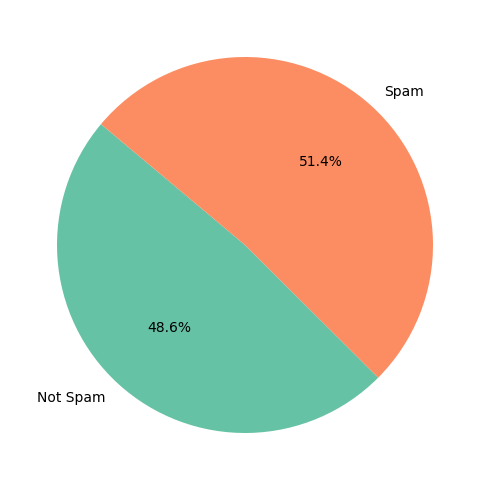

In [ ]:

spam_counts = df['CLASS'].value_counts().sort_index()

palette = sns.color_palette("Set2", n_colors=len(spam_counts))
fig = plt.figure(figsize=(7, 5))
plt.pie(spam_counts, autopct='%1.1f%%', startangle=140, colors=palette, labels=["Not Spam", "Spam"])
plt.tight_layout()
plt.show()

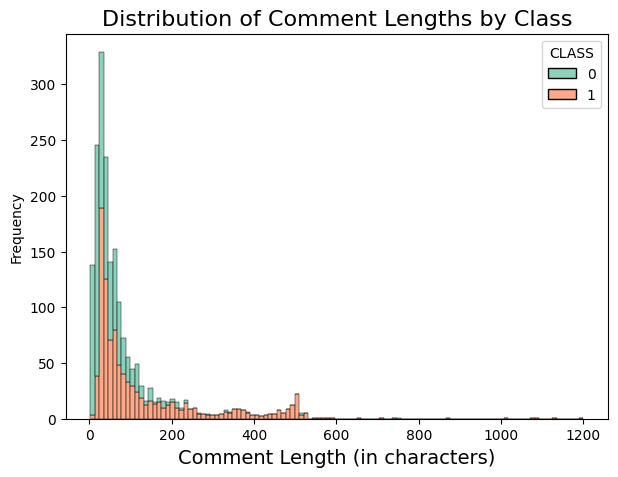

In [ ]:

df['Comment Length'] = df['CONTENT'].apply(len)


plt.figure(figsize=(7, 5))
sns.histplot(df, x='Comment Length', hue='CLASS', multiple='stack', palette='Set2')
plt.title('Distribution of Comment Lengths by Class', fontsize=16)
plt.xlabel('Comment Length (in characters)', fontsize=14)
plt.ylabel('Frequency')
plt.show()

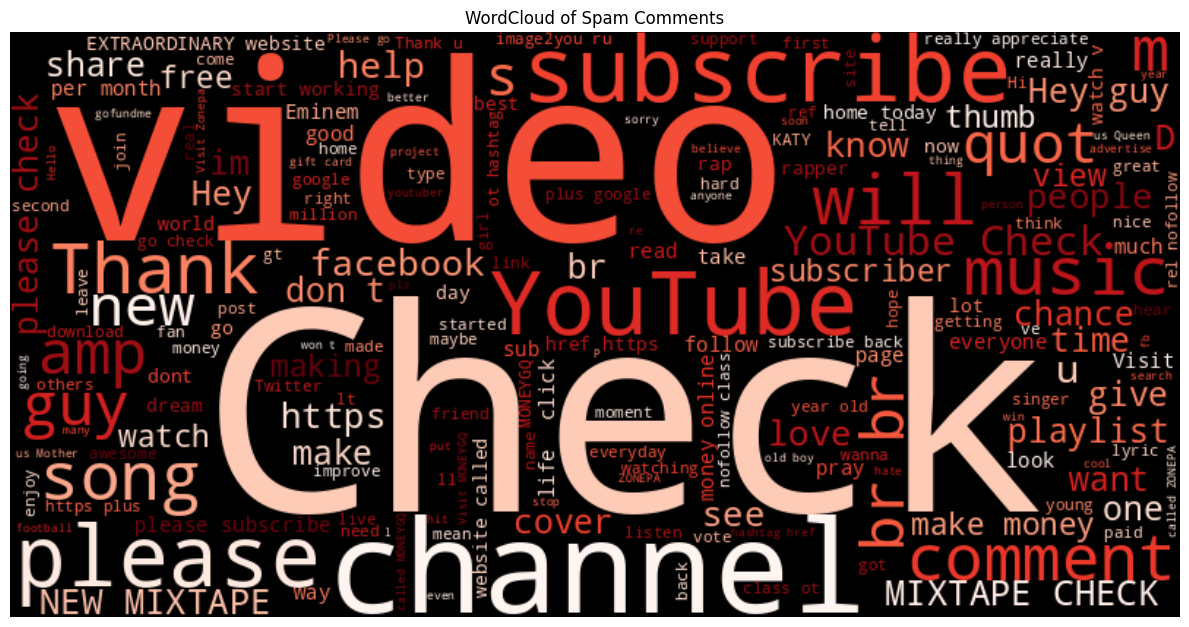

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all spam comments into a single string
spam_comments = ' '.join(df[df['CLASS'] == 1]['CONTENT'])

# Generate the WordCloud for spam comments
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_comments)

# Plot the WordCloud
plt.figure(figsize=(12, 8))
plt.imshow(spam_wordcloud, interpolation='bilinear')

plt.axis('off')
plt.title('WordCloud of Spam Comments')
plt.tight_layout()
plt.show()

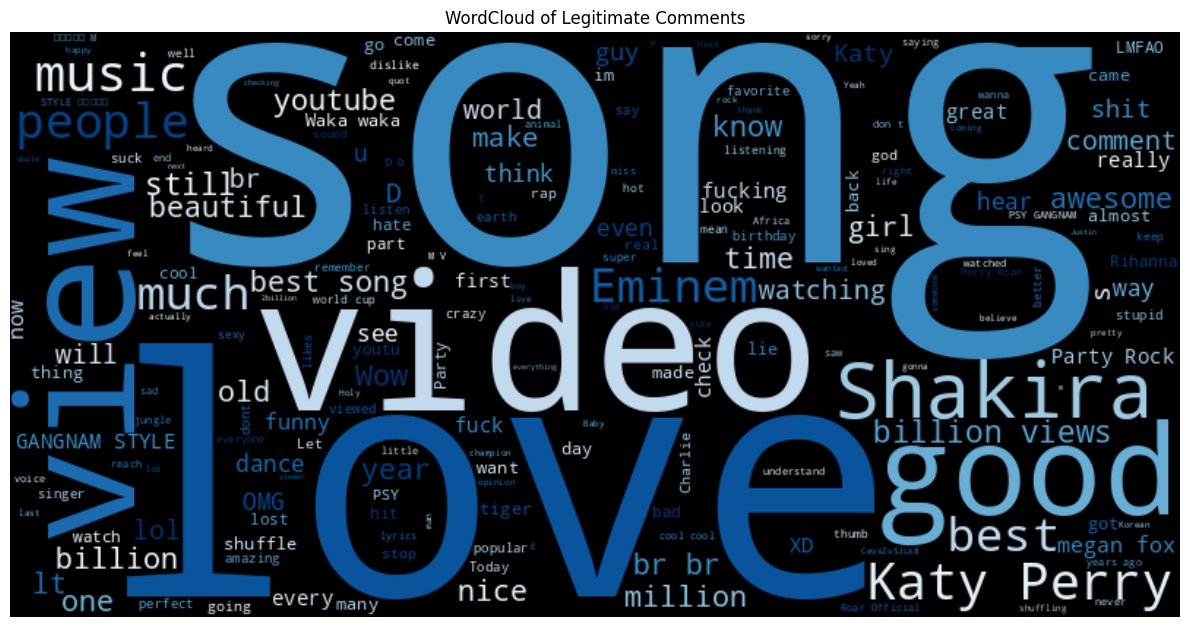

In [ ]:

# Concatenate all legitimate comments into a single string
legitimate_comments = ' '.join(df[df['CLASS'] == 0]['CONTENT'])

# Generate the WordCloud for legitimate comments
legitimate_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(legitimate_comments)

# Plot the WordCloud
plt.figure(figsize=(12, 8))
plt.imshow(legitimate_wordcloud, interpolation='bilinear')

plt.axis('off')
plt.title('WordCloud of Legitimate Comments')
plt.tight_layout()
plt.show()

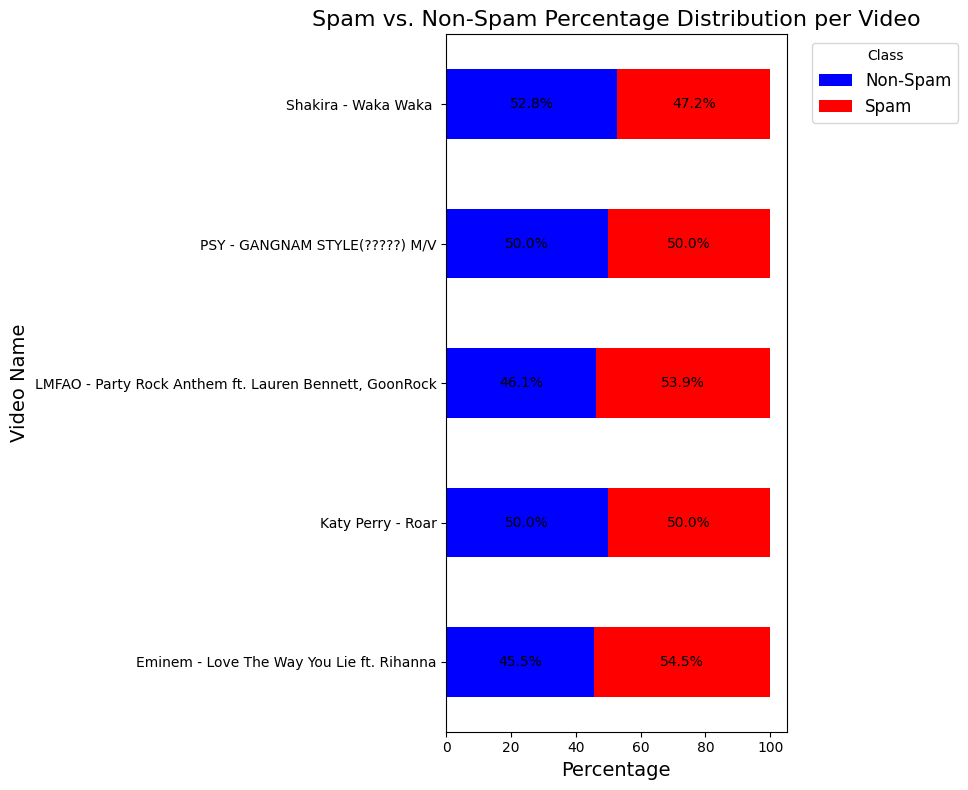

In [ ]:
video_class_counts = df.groupby(['VIDEO_NAME', 'CLASS']).size().unstack(fill_value=0)

# Calculate the percentage for each class (spam/non-spam)
video_class_percent = video_class_counts.div(video_class_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar plot for spam vs. non-spam distribution per video (horizontal)
plt.figure(figsize=(10, 8))
ax = video_class_percent.plot(kind='barh', stacked=True, color=['blue', 'red'], ax=plt.gca())

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

# Move the legend outside of the plot
ax.legend(title='Class', labels=['Non-Spam', 'Spam'], fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Spam vs. Non-Spam Percentage Distribution per Video', fontsize=16)
plt.ylabel('Video Name', fontsize=14)
plt.xlabel('Percentage', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

ML Apply

In [ ]:
# prompt: download df

from google.colab import files
df.to_csv('youtube_spam_data.csv', encoding = 'utf-8-sig')
files.download('youtube_spam_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize stemmer and lemmatizer
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Text preprocessing functions
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def tokenization(text):
    tokens = re.split(r'\W+', text)  # Corrected regex for splitting
    return tokens

def remove_stopwords(tokens):
    stopwords_list = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords_list]

def stemming(tokens):
    stemmed_text = [porter_stemmer.stem(word) for word in tokens]
    return stemmed_text

# Load dataset
#data = pd.read_csv('/content/Youtube-Spam-Dataset.csv')
df = data[['CONTENT', 'CLASS']]

# Apply text preprocessing
data['CONTENT'] = data['CONTENT'].apply(lambda x: remove_punctuation(x))
data['CONTENT'] = data['CONTENT'].apply(lambda x: x.lower())
data['CONTENT'] = data['CONTENT'].apply(lambda x: tokenization(x))
data['CONTENT'] = data['CONTENT'].apply(lambda x: remove_stopwords(x))
data['CONTENT'] = data['CONTENT'].apply(lambda x: stemming(x))

# Join the tokens back into a string for each row
data['CONTENT'] = data['CONTENT'].apply(lambda x: ' '.join(x))

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = data['CONTENT']
y = data['CLASS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Vectorize the text data
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NameError: name 'data' is not defined

In [ ]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1467, 3605), (489, 3605), (1467,), (489,))

In [ ]:


# 1. Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_train_accuracy = accuracy_score(y_train, dt_classifier.predict(X_train))
dt_test_accuracy = accuracy_score(y_test, dt_predictions)

print("Decision Tree Train Accuracy:", dt_train_accuracy)
print("Decision Tree Test Accuracy:", dt_test_accuracy)

# 2. Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_train_accuracy = accuracy_score(y_train, nb_classifier.predict(X_train))
nb_test_accuracy = accuracy_score(y_test, nb_predictions)

print("\nNaive Bayes Train Accuracy:", nb_train_accuracy)
print("Naive Bayes Test Accuracy:", nb_test_accuracy)

# 3. Linear Regression (Regression task, not classification)
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)
lr_predictions = lr_regressor.predict(X_test)

# For regression, use a different metric like mean squared error.
# Here, we're converting predictions to classes (0 or 1) for comparison.
lr_predictions_class = np.round(lr_predictions)
lr_train_accuracy = accuracy_score(y_train, np.round(lr_regressor.predict(X_train)))
lr_test_accuracy = accuracy_score(y_test, lr_predictions_class)

print("\nLinear Regression Train Accuracy:", lr_train_accuracy)
print("Linear Regression Test Accuracy:", lr_test_accuracy)

# 4. Logistic Regression
logreg_classifier = LogisticRegression(max_iter=1000) # Increase max_iter if needed
logreg_classifier.fit(X_train, y_train)
logreg_predictions = logreg_classifier.predict(X_test)
logreg_train_accuracy = accuracy_score(y_train, logreg_classifier.predict(X_train))
logreg_test_accuracy = accuracy_score(y_test, logreg_predictions)

print("\nLogistic Regression Train Accuracy:", logreg_train_accuracy)
print("Logistic Regression Test Accuracy:", logreg_test_accuracy)

# 5. Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_train_accuracy = accuracy_score(y_train, rf_classifier.predict(X_train))
rf_test_accuracy = accuracy_score(y_test, rf_predictions)

print("\nRandom Forest Train Accuracy:", rf_train_accuracy)
print("Random Forest Test Accuracy:", rf_test_accuracy)

# 6. KNN Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_train_accuracy = accuracy_score(y_train, knn_classifier.predict(X_train))
knn_test_accuracy = accuracy_score(y_test, knn_predictions)

print("\nKNN Classifier Train Accuracy:", knn_train_accuracy)
print("KNN Classifier Test Accuracy:", knn_test_accuracy)

# 7. KNN Regressor (Regression task, not classification)
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train, y_train)
knnr_predictions = knn_regressor.predict(X_test)
knnr_predictions_class = np.round(knnr_predictions)
knnr_train_accuracy = accuracy_score(y_train, np.round(knn_regressor.predict(X_train)))
knnr_test_accuracy = accuracy_score(y_test, knnr_predictions_class)

print("\nKNN Regressor Train Accuracy:", knnr_train_accuracy)
print("KNN Regressor Test Accuracy:", knnr_test_accuracy)

# 8. SVM/SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_predictions)

print("\nSVM/SVC Train Accuracy:", svm_train_accuracy)
print("SVM/SVC Test Accuracy:", svm_test_accuracy)

Decision Tree Train Accuracy: 1.0
Decision Tree Test Accuracy: 0.8875255623721882

Naive Bayes Train Accuracy: 0.9686434901158828
Naive Bayes Test Accuracy: 0.8568507157464212

Linear Regression Train Accuracy: 0.9986366734832992
Linear Regression Test Accuracy: 0.7525562372188139

Logistic Regression Train Accuracy: 0.9679618268575324
Logistic Regression Test Accuracy: 0.8813905930470347

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.8875255623721882

KNN Classifier Train Accuracy: 0.6550783912747103
KNN Classifier Test Accuracy: 0.6032719836400818

KNN Regressor Train Accuracy: 0.6550783912747103
KNN Regressor Test Accuracy: 0.6032719836400818

SVM/SVC Train Accuracy: 0.9965916837082481
SVM/SVC Test Accuracy: 0.8813905930470347


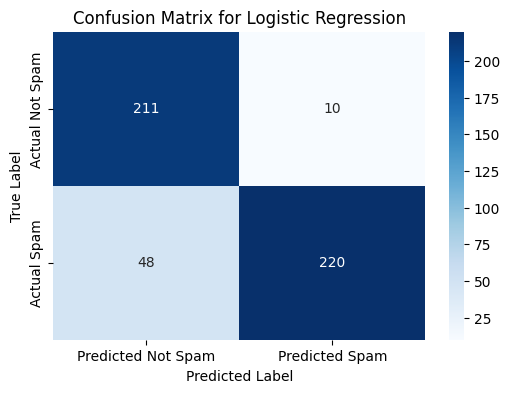

In [ ]:

cm = confusion_matrix(y_test, logreg_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Not Spam', 'Predicted Spam'],
            yticklabels=['Actual Not Spam', 'Actual Spam'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Apply ANN

In [ ]:

model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),  # Add dropout for regularization
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1) # Adjust epochs and batch size as needed

# Evaluate the model on the training data
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\nANN Train Accuracy: {train_accuracy}")

# Evaluate the model on the test data
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"ANN Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5978 - loss: 0.6836 - val_accuracy: 0.8571 - val_loss: 0.5936
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8763 - loss: 0.4948 - val_accuracy: 0.8844 - val_loss: 0.2562
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9746 - loss: 0.1264 - val_accuracy: 0.8844 - val_loss: 0.2643
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9911 - loss: 0.0483 - val_accuracy: 0.8707 - val_loss: 0.2409
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9952 - loss: 0.0259 - val_accuracy: 0.8776 - val_loss: 0.2809
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9920 - loss: 0.0177 - val_accuracy: 0.8707 - val_loss: 0.2678
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9982 - loss: 0.0092 - val_accuracy: 0.8639 - val_loss: 0.3213
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8776 - v

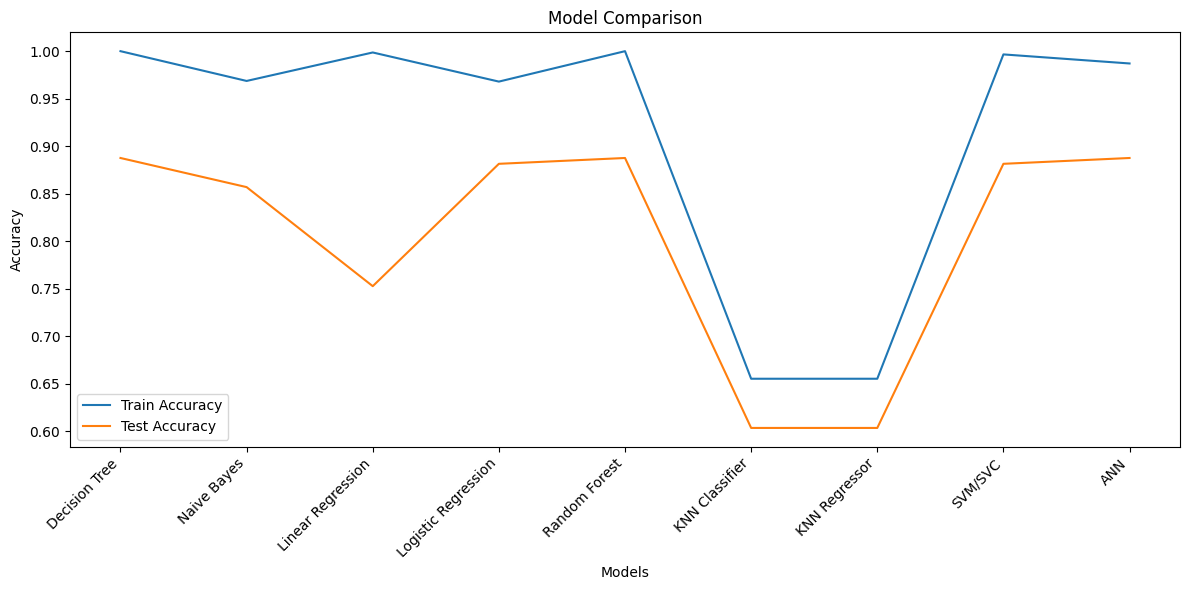

In [ ]:

models = ['Decision Tree', 'Naive Bayes', 'Linear Regression', 'Logistic Regression', 'Random Forest', 'KNN Classifier', 'KNN Regressor', 'SVM/SVC', 'ANN']
train_accuracies = [dt_train_accuracy, nb_train_accuracy, lr_train_accuracy, logreg_train_accuracy, rf_train_accuracy, knn_train_accuracy, knnr_train_accuracy, svm_train_accuracy, train_accuracy]
test_accuracies = [dt_test_accuracy, nb_test_accuracy, lr_test_accuracy, logreg_test_accuracy, rf_test_accuracy, knn_test_accuracy, knnr_test_accuracy, svm_test_accuracy, test_accuracy]


plt.figure(figsize=(12, 6))
plt.plot(models, train_accuracies, label='Train Accuracy')
plt.plot(models, test_accuracies, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

**Privious work**



*    Leveraging the Ensemble Model in Spam detection for Youtube Comments

       Best Model: ARIMA+E-GARCH
      Best Accuracy: 95% detection rate



*   An Extensive Review on Contemporary Analysis of Comment Filtration of YouTube Videos Using Machine Learning Techniques.
     AGA (Adaptive Genetic Algorithm):
     99.11% accuracy


*   The title is Spam detection for Youtube video comments using machine learning approaches.
    The Random Forest model
    100% accuracy


*  Hybrid deep learning model for YouTube spam comment detection.
      CNN-biLSTM (Bidirectional Long Short-Term Memory)
      accuracy of 96.94%.




*   DeepGram: Combining Language Transformer and N-Gram-Based ML Models for YouTube Spam Comment Detection
      deepGram (combining language transformer and N-gram features)
       (90-97)%


*   Spam Detection in YouTube Comments Using Deep Learning Models: A Comparative Study of MLP, CNN, LSTM, BiLSTM, GRU, and Attention Mechanisms
  Best Model: LSTM
  Best Accuracy: 95.65% (test accuracy)



*  Spam Detection on YouTube Comments Using Advanced Machine Learning Models: A Comparative Study
     Best Model: Linear Support Vector Classifier (LinearSVC)
     Best Accuracy: 96% (on the test set), 95.33% (cross-validation)


*  



   


